# Single perceptron

We want to implement a single layer perceptron to classify AND, OR and XOR using perceptron learning and delta rule.

In this particular case, we will use the same 4 sets of binary data to train the perceptron. We call this `epoch`.

For the OR case:

|inputs||target|
|------||------|
|0 | 0 |      0|
|0 | 1 |      1|
|1 | 0 |      1|
|1 | 1 |      1|

For the AND case:

|inputs||target|
|------||------|
|0 | 0 |      0|
|0 | 1 |      0|
|1 | 0 |      0|
|1 | 1 |      1|

And for the XOR case:

|inputs||target|
|------||------|
|0 | 0 |      0|
|0 | 1 |      1|
|1 | 0 |      1|
|1 | 1 |      0|

The perceptron will have two inputs $ x_0 $ and $ x_1 $ and an extra "bias" input $ x_2 = 1 $. There will be three weights $ w_0, w_1, w_2 $ and an output $ y $.

The inputs, outputs and bias are related by the relation:

$$ y = \mathbf{Wx}^\text{T} $$

where $ \mathbf{W} = [w_0, w_1, w_2] $ and $ \mathbf{x} = [x_0, x_1, x_2] $

This relation is derived from the following figure:

<img src="perceptron.png" />

Explicitly:

$$ y = w_0 \cdot x_0 + w_1 \cdot x_1 + w_2 \cdot x_2 $$

This particular perceptron does not have a threshold unit. We will add a threshold unit to the output defined as:

$$
\text{sgn}(x) = \cases{
    -1, & if $x\lt0$\cr
    1, & if $x\gt0$ \cr
} = \frac{x}{|x|}
$$

We break the process into two steps: training and prediction. In the training phase we show the perceptron example data and expected outputs and let it adjust its weights. In the prediction phase we validate whether the perceptron was able to successfully classify the data. 

The weights and biases form a plane in 3-dimensional space that bisects the 2d plane. The weights $ w_0 $ and $ w_1 $ define the normal of the plane (and thus its orientation) while the weight $ w_2 $ defines its translation from the origin.

In [1]:
# import python packages

%matplotlib inline

from pylab import * # for plotting
from numpy import * # for matrix and numerical libraries

## Training

We will first implement the training step of the perceptron. The training step will accept the following parameters:

```
inputs (x) : the input patterns (a 2xn matrix containing n examples)
targets (t) : the target patterns (a 1xn vector)
learningRate (eta) : the step size of the gradient descent
epochs : number of times the input and target will be trained
```

### Perceptron learning

As stated earlier, the network learns by adjusting its weights. We need a strategy to update these weights. The simple strategy is to perform a forward pass

$$ y = \text{sgn}(\mathbf{Wx}^T) $$

and compute the error

$$ e = y - t $$

(where t is the target pattern) and calculating

$$ \Delta W = \eta \mathbf{x} e $$.

We can then update the weights with:

$$ \mathbf{W} = \mathbf{W} + \Delta W $$

This is called perceptron learning.

Let us create a simple training function.

In [2]:
def train_pl(inputs, targets, eta=0.01, epochs=200):
    bias = ones((1, inputs.shape[1])) # create a 1xn vector of 1s as our bias
    X = vstack((inputs, bias)) # add bias to the inputs, resulting in a 3xn matrix
    
    weights = random.randn(1, X.shape[0]) # create a 1x3 vector of random weights
    error = zeros(epochs) # create a vector to store error computed at each epoch
    
    for i in range(epochs):
        err = (sign(weights * X) - targets)
        deltaW = -eta * err * X.T
        weights = weights + deltaW # update weights
        error[i] = mean(power(err, 2)) # calculate mean square error for each epoch
    
    return weights, error

The training function takes inputs and targets and returns weights of the trained network. It also returns an error so that we can observe the evolution of the network. Let us run it with a OR dataset, note that we replace 0 with a -1 because we want to make the inputs and targets symmetric (to prevent premature termination of learning).

Let us define a function that makes our binary values symmetric.

In [3]:
def symmetric(v):
    """
        if v = 0:
            2 * (0 - 0.5) = 2 * (-0.5) = -1
        if v = 1
            2 * (1 - 0.5) = 2 * (0.5) = 1
    """
    return 2 * (v - 0.5)

OR_X = symmetric(matrix("""
0 1 0 1;
0 0 1 1
"""))

OR_T = symmetric(matrix("""
0 1 1 1
"""))

print(OR_X)
print(OR_T)

[[-1.  1. -1.  1.]
 [-1. -1.  1.  1.]]
[[-1.  1.  1.  1.]]


We are now ready to train our simple perceptron for the OR dataset.

Text(0.5,1,'MSE when training with pereptron learning')

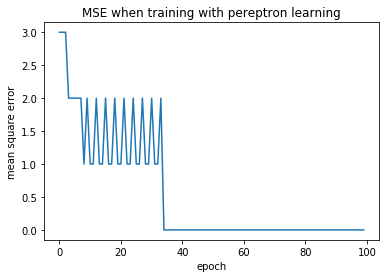

In [4]:
W, err = train_pl(OR_X, OR_T, eta=0.01, epochs=100) # perform training

# plot error
figure()
plot(err)
xlabel('epoch')
ylabel('mean square error')
title('MSE when training with pereptron learning')


Hmm ... we can see the the network was able to classify successfully. But the curve looks really strange, it is difficult to see how the network has drawn the decision boundary (the plane in 3-d space) from this view. A better way is to rearrange our output equation so that we can see the decision boundary in a more clear way.

Given that we have:

$$
\begin{align}
y & = w_0 x_0 + w_1 x_1 + w_2 x_2 \\\\
& = w_0 x_0 + w_1 x_1 + w_2 \ \text{(since $ x_2 = 1 $)}
\end{align}
$$

The definition of a plane is:

$$
0 = ax + by + c
$$

Where a, b and c are the normals of the plane. Since we want to find the plane defined by the weight matrices, we set $ y = 0 $.

Let us rearrange the equation in terms of $ x_0 $ (the decision is arbitrary, we could have chosen $ x_1 $ as well).

$$
\begin{align}
0 & = w_0 x_0 + w_1 x_1 + w_2 \\\\
w_0 x_0 + w_1 x_1 & = -w_2 \\\\
w_0 x_0 & = -w_1 x_1 - w_2 \\\\
x_0 & = -\frac{w_1}{w_0} x_1 - \frac{w_2}{w_0} \\\\
x_0 & = m x + b
\end{align}
$$

In order to draw the decision boundary we need to first plot our data points.

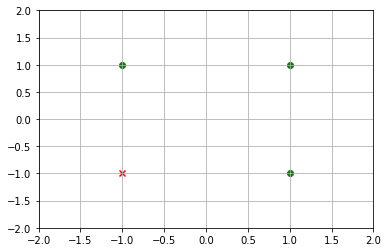

In [5]:
pos = OR_X[:,where(OR_T > 0)[1]] # find points where T > 0
neg = OR_X[:,where(OR_T < 0)[1]] # find points where T < 0

figure()
scatter([pos[0,:]], [pos[1,:]], marker='o', c='g') # plot positive points with a green circle
scatter([neg[0,:]], [neg[1,:]], marker='x', c='r') # plot negative points with a red cross
xlim([-2, 2])
ylim([-2, 2])
grid()

Now we can calculate the decision boundary using the weights and plot it on top of our plot to get a better understanding of how the training went.

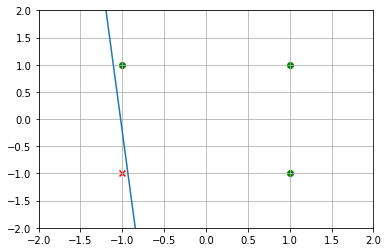

In [6]:
x = linspace(-2, 2, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary

figure()
scatter([pos[0,:]], [pos[1,:]], marker='o', c='g') # plot positive points with a green circle
scatter([neg[0,:]], [neg[1,:]], marker='x', c='r') # plot negative points with a red cross
plot(x, boundary)
xlim([-2, 2])
ylim([-2, 2])
grid()

It is now much easier to see the decision boundary. However, it is quite clear that this is not the optimal decision boundary and it looks as if the network stopped learning a bit early as the line is closer to the (1,-1) point than the (-1, 1) point. We know it is not an issue of not enough epochs because the MSE graph shows that the error converged to 0.

We need a better solution.

### Delta Rule (Widrow-Hoff rule)

When using perceptron learning we calculated the error by comparing the thresholded output to the targets. A better strategy is to use the unthresholded output to the target as this allows a much better estimate of the error surface allowing us to find the optimal decision boundary for the single-perceptron case.

We change the error function from:

$$
e = \text{sgn}(\mathbf{Wx}^T) - t
$$

to:

$$
e = \mathbf{Wx}^T - t
$$

This requires only a single change in our training function.

In [7]:
def train_dr(inputs, targets, eta=0.01, epochs=200):
    bias = ones((1, inputs.shape[1])) # create a 1xn vector of 1s as our bias
    X = vstack((inputs, bias)) # add bias to the inputs, resulting in a 3xn matrix
    
    weights = random.randn(1, X.shape[0]) # create a 1x3 vector of random weights
    error = zeros(epochs) # create a vector to store error computed at each epoch
    
    for i in range(epochs):
        err = ((weights * X) - targets) # NOTE CHANGE HERE!!
        deltaW = -eta * err * X.T
        weights = weights + deltaW # update weights
        error[i] = mean(power(err, 2)) # calculate mean square error for each epoch
    
    return weights, error

Training and plotting the decision boundary and error curve:

Text(0.5,1,'MSE when training with delta rule')

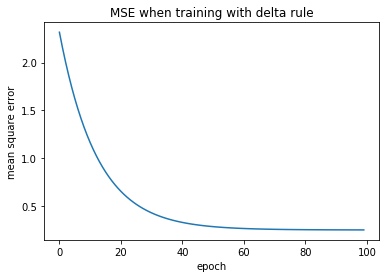

In [8]:
W, err = train_dr(OR_X, OR_T, eta=0.01, epochs=100) # perform training

# plot error
figure()
plot(err)
xlabel('epoch')
ylabel('mean square error')
title('MSE when training with delta rule')

We see that the error curve is much smoother because we are not thresholding the output.

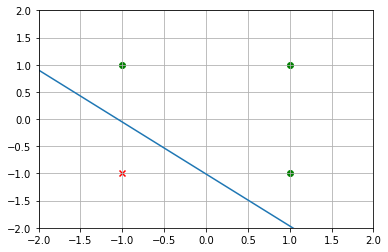

In [9]:
x = linspace(-2, 2, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary

figure()
scatter([pos[0,:]], [pos[1,:]], marker='o', c='g') # plot positive points with a green circle
scatter([neg[0,:]], [neg[1,:]], marker='x', c='r') # plot negative points with a red cross
plot(x, boundary)
xlim([-2, 2])
ylim([-2, 2])
grid()

The decision boundary separates the two datasets well. Let us now use the network to classify the AND function.

In [10]:
AND_X = symmetric(matrix("""
0 1 0 1;
0 0 1 1
"""))

AND_T = symmetric(matrix("""
0 0 0 1
"""))

pos = AND_X[:,where(AND_T > 0)[1]] # find points where T > 0
neg = AND_X[:,where(AND_T < 0)[1]] # find points where T < 0

print(AND_X)
print(AND_T)

[[-1.  1. -1.  1.]
 [-1. -1.  1.  1.]]
[[-1. -1. -1.  1.]]


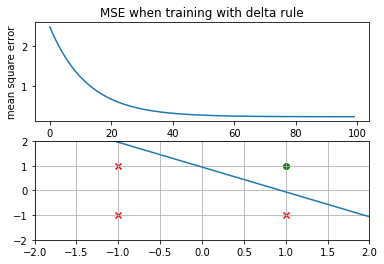

In [11]:
W, err = train_dr(AND_X, AND_T, eta=0.01, epochs=100) # perform training

x = linspace(-2, 2, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary

# plot error
subplot(2, 1, 1)
plot(err)
xlabel('epoch')
ylabel('mean square error')
title('MSE when training with delta rule')

subplot(2, 1, 2)
scatter([pos[0,:]], [pos[1,:]], marker='o', c='g') # plot positive points with a green circle
scatter([neg[0,:]], [neg[1,:]], marker='x', c='r') # plot negative points with a red cross
plot(x, boundary)
xlim([-2, 2])
ylim([-2, 2])
grid()

# Assignment Part I

## Classification with single-layer perceptron

### Generate linearly separable data

We can generate a sample of normally distributed multivariate data centered at `mu` and with covariance `cov` using the following functions. 

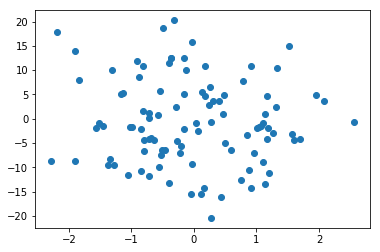

In [12]:
mu = [0, 0]
cov = [[1, 0], [0, 100]]
x, y = random.multivariate_normal(mu, cov, 100).T
scatter(x, y)

Let us package it into a function so that we can generate labels and data.

(-40, 40)

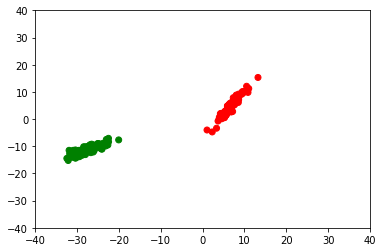

In [44]:
def gen_data(mu, label, n=100):
    v = random.randint(0, 10, size=(2,2))
    cov = dot(v, v.T)*0.1
    data = random.multivariate_normal(mu, cov, n).T
    labels = label * ones((1, n))
    return vstack((data, labels))

data = hstack((gen_data(random.randint(0, 20, size=2), 0), gen_data(random.randint(-30, 0, size=2), 1)))
colors = ['red', 'green']
random.shuffle(data.T)
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
xlim([-40, 40])
ylim([-40, 40])

Let us implement sequential learning for both delta and perceptron learning. Instead of creating new functions, let us define a function `train` that takes different parameters.

Our `train` function should take the following parameters:

```
inputs : the inputs to train
targets : the targets we are trying to match
eta : the learning rate
activation : the activation function (such as sgn)
batch : whether to train in batch mode or not
```

[[  6.94912447e+53   9.08432991e+53  -3.18570123e+53  -2.24750227e+53
   -2.06155508e+53  -1.72286020e+53   9.07940519e+53   1.06433012e+54
   -2.60759965e+53   9.81879063e+53   9.24451918e+53  -1.74867959e+53
   -1.33479415e+53   8.85327646e+53  -2.36526179e+53  -4.17850751e+52
    9.29635072e+53  -2.11607498e+53   1.01631924e+54   1.08696194e+54
   -2.10908480e+53  -1.77248169e+53  -1.66781243e+53  -2.90457113e+53
    8.97996986e+53   1.01658992e+54  -2.02597906e+53   8.28357561e+53
   -3.25807424e+53   1.01419303e+54  -1.97651030e+53   9.10570198e+53
   -1.20284440e+53   8.94219865e+53  -2.09307174e+53  -1.68068987e+53
    1.01626392e+54  -2.30015542e+53  -2.18145123e+53   9.57017024e+53
    9.78220633e+53  -2.04703033e+53   9.30788515e+53   9.23933620e+53
   -1.68842519e+53   9.78219084e+53   8.34111260e+53   9.18588445e+53
    9.42450900e+53  -1.97871636e+53   9.16536142e+53   1.02054261e+54
   -1.79630363e+53  -2.49179104e+53   9.44103313e+53  -2.84502475e+53
    9.40041207e+53  

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  n

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  n

(-40, 40)

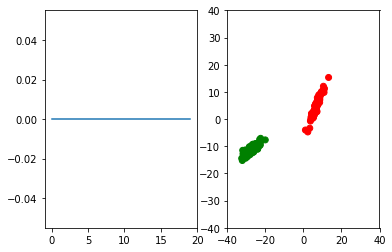

In [173]:
def train(inputs, targets, eta=0.01, activation=lambda x: x, batch=True, epochs=200):
    bias = ones((1, inputs.shape[1])) # create a 1xn vector of 1s as our bias
    X = vstack((inputs, bias)) # add bias to the inputs, resulting in a 3xn matrix

    weights = random.rand(1, X.shape[0]) # create a 1x3 vector of random weights
    error = zeros(epochs) # create a vector to store error computed at each epoch
    
    if batch:    
        for i in range(epochs):
            err = (activation(dot(weights, X)) - targets)
            deltaW = -eta * dot(err, X.T)
            weights = weights + deltaW # update weights
            error[i] = mean(power(err, 2)) # calculate mean square error for each epoch
    else:
        for i in range(epochs):
            for j in range(X.shape[1]):
                err = (activation(dot(weights, X[:,j])) - targets[j])
                deltaW = -eta * err * X[:,j]
                weights = weights + deltaW # update weights
            
            err = (activation(dot(weights, X)) - targets)
            error[i] = mean(power(err, 2)) # calculate mean square error for each epoch
    return weights, error

W, err = train(data[0:2,:], data[2,:], batch=False, epochs=20)
subplot(1, 2, 1)
plot(err)
subplot(1, 2, 2)
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
x = linspace(-40, 40, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary
plot(x, boundary)
xlim([-40, 40])
ylim([-40, 40])

#### Perceptron learning batch mode

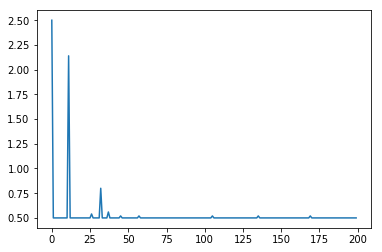

In [146]:
W, err = train(data[0:2,:], data[2,:], activation=sign, batch=True)
plot(err)

(-40, 40)

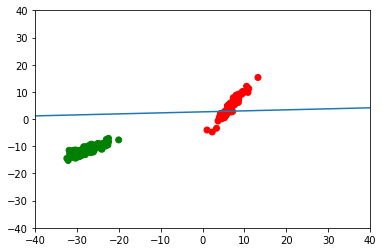

In [147]:
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
x = linspace(-40, 40, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary
plot(x, boundary)
xlim([-40, 40])
ylim([-40, 40])

#### Perceptron learning sequential mode

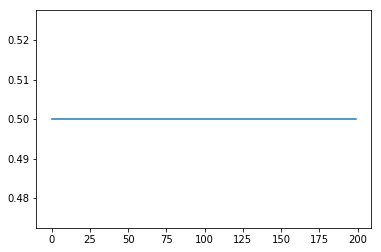

In [148]:
W, err = train(data[0:2,:], data[2,:], activation=sign, batch=False)
plot(err)

(-40, 40)

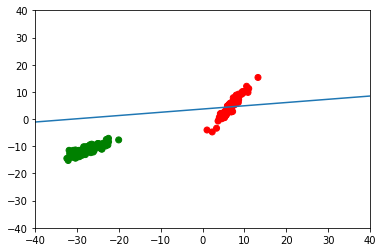

In [149]:
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
x = linspace(-40, 40, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary
plot(x, boundary)
xlim([-40, 40])
ylim([-40, 40])

#### Delta Rule batch mode

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]


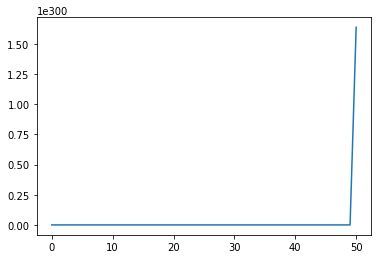

In [150]:
W, err = train(data[0:2,:], data[2,:])
plot(err)

(-40, 40)

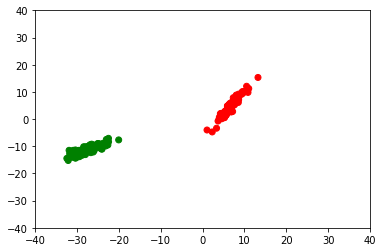

In [151]:
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
x = linspace(-40, 40, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary
plot(x, boundary)
xlim([-40, 40])
ylim([-40, 40])

#### Delta Rule sequential mode

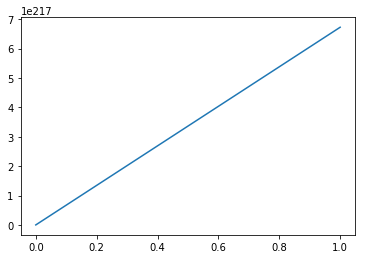

In [152]:
W, err = train(data[0:2,:], data[2,:], batch=False, epochs=2)
plot(err)

(-40, 40)

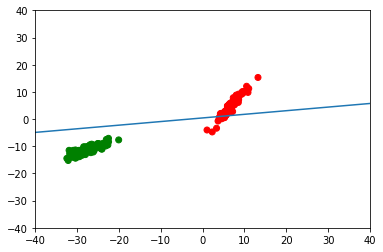

In [98]:
scatter(data[0,:], data[1,:], c=data[2,:], cmap=matplotlib.colors.ListedColormap(colors))
x = linspace(-40, 40, 2) # generate two values between -2 and 2
boundary = -(W[0,1] / W[0,0]) * x - (W[0,2] / W[0,0]) # calculate the decision boundary
plot(x, boundary)
xlim([-40, 40])
ylim([-40, 40])